In [1]:
"""An example notebook for a data_analysis notebook you may write.

Please use the recommended TNR font unless your venue requires otherwise.
"""

# Write down all of your code for data analysis in this file.
# Plot the data and save the figures/tables in the folders "plots" and "tables"

import seaborn as sns
# Whitegrid is most appropriate
# for scientific papers
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
# Use TNR for all figures
# to match paper templates
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = [
    "Times New Roman",
] + plt.rcParams["font.serif"]


# An optional colorblind palette
# for figures
CB_color_cycle = [
    "#377EB8",
    "#FF7F00",
    "#4DAF4A",
    "#F781BF",
    "#A65628",
    "#984EA3",
    "#999999",
    "#E41A1C",
    "#DEDE00",
]

In [2]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
from typing import List, Tuple
from dataclasses import dataclass

# 0. Rando

/tmp/ipykernel_283551/2625252216.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  histplot = sns.histplot(


mode=165.5929648241206


/tmp/ipykernel_283551/2625252216.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  histplot = sns.histplot(
/tmp/ipykernel_283551/2625252216.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  histplot = sns.histplot(


mode=140.31658291457285
mode=140.58793969849245


/tmp/ipykernel_283551/2625252216.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  histplot = sns.histplot(


mode=143.17085427135677


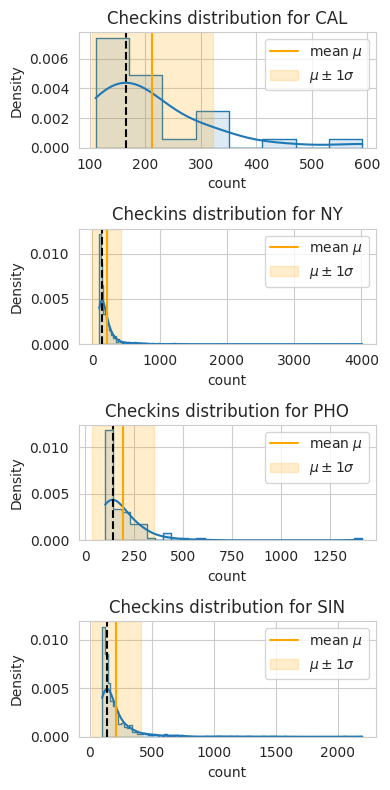

In [41]:
fig, axes = plt.subplots(4, 1, squeeze=False, figsize=(4, 8))
for i, city in enumerate(("CAL", "NY", "PHO", "SIN")):
    postprocessed_path = Path.cwd().parent / "data" / "flashback" / "partition" / city / "centralised" / "client_0.txt"
    df_postprocessed = pd.read_csv(postprocessed_path, sep="\t", header=None)
    checkin_distribution_postprocessed = df_postprocessed.loc[:, 0].value_counts()
    binwidth = (checkin_distribution_postprocessed.max() - checkin_distribution_postprocessed.min()) // 20

    histplot = sns.histplot(
        alpha=0.15,
        legend=True,
        data=checkin_distribution_postprocessed,
        fill=True,
        kde=True,
        element="step",
        stat="density",
        common_norm=False,  # there is only 1 histogram here, so this is inconsequential
        common_bins=True,
        cbar=True,  # this is a univariate plot (1 dependent variable: # samples), so this is inconsequential
        palette="dark",
        ax=axes[i, 0]
    )  # corresponds to histplot.get_lines()[0]
    mu = np.mean(checkin_distribution_postprocessed)
    sigma = np.std(checkin_distribution_postprocessed)  # standard deviation
    axes[i, 0].axvline(mu, color="orange", label="mean $\mu$")  # corresponds to histplot.get_lines()[1]
    axes[i, 0].axvspan(mu - sigma, mu + sigma, label="$\mu \pm 1 \sigma$", color="orange", alpha=0.2)
    axes[i, 0].legend()

    # Mode finding from KDE courtesy of https://stackoverflow.com/a/72222126
    x, y = histplot.get_lines()[0].get_data()
    mode = x[np.argmax(y)]
    print(f"mode={mode}")
    axes[i, 0].axvline(mode, ls="--", color="black")  # For demo purposes only

    axes[i, 0].set_title(f"Checkins distribution for {city}")

    # plt.xlabel("# samples")

    # fig, axes = plt.subplots(1, 2, figsize=(9, 2), squeeze=False)
    # sns.histplot(checkin_distribution_raw, stat="count", binwidth=binwidth, ax=axes[0, 0])
    # sns.histplot(checkin_distribution_postprocessed, stat="count", binwidth=binwidth, ax=axes[0, 1])
    # axes[0, 0].set_title("Raw dataset")
    # axes[0, 0].set_yscale("log")
    # axes[0, 1].set_title("Flashback-Postprocessed dataset\nmust have at least $101$ checkins")
    # axes[0, 1].set_yscale("log")
    # fig.suptitle(f"Checkins distribution for {city}", y=1.2)
    # plt.show()
    # break

plt.tight_layout()
plt.show()

In [115]:
from numpy.typing import ArrayLike
def find_mode(distribution: ArrayLike) -> float:
    histplot = sns.histplot(data=distribution, kde=True, element="step")  # corresponds to histplot.get_lines()[0]
    plt.close()  # prevent showing of plot

    # Mode finding from KDE courtesy of https://stackoverflow.com/a/72222126
    x, y = histplot.get_lines()[0].get_data()
    mode = x[np.argmax(y)]
    return mode

find_mode([1,2,3,4,5,6,7,7,7,7,8])

6.663316582914573

In [127]:
sequence_length=20

In [144]:
city = "CAL"
df = pd.read_csv(Path.cwd().parent / "data" / "flashback" / "raw_data" / city / "CAL_checkin.csv")
df = df.loc[:, ["UserId", "Local_Time", "Latitude", "Longitude", "VenueId"]]

# Deal with time
df.loc[:, "Local_Time"] = pd.to_datetime(
    df.loc[:, "Local_Time"],
    dayfirst=city == "CAL",  # peculiarity of the MCMG dataset
    yearfirst=city != "CAL",  # peculiarity of the MCMG dataset
    utc=True,
)
df.loc[:, "Local_Time"] = df.loc[:, "Local_Time"].apply(
    lambda t: t.strftime("%Y-%m-%dT%H:%M:%SZ")
)
df = df.sort_values(
    by=["UserId", "Local_Time"]
)  # Flashback expects checkins from the same user to be bunched together

debug_total_checkins_before_drop = len(df)
debug_total_users_before_drop = len(df.loc[:, "UserId"].unique())

# Drop users with insufficient checkins
required_minimum_checkins = 5 * sequence_length + 1
print(f"With sequence_length={sequence_length}, we have required_minimum_checkins={required_minimum_checkins}")
num_checkins_per_user = df.loc[:, "UserId"].value_counts()
df.loc[:, "num_checkins_from_this_user"] = df.loc[:, "UserId"].apply(
    lambda i: num_checkins_per_user[i]
)
df = df.loc[
    df.loc[:, "num_checkins_from_this_user"] >= required_minimum_checkins,
    :  #* this column is useful for within-barricade operations below, retain it for now
]

# * Extra processing compared to _preprocess_data_all_clients() happens within
# * these barricades
# * //////////////////////////////////////////////////////////////////////// * #

# Checkins distribution
num_checkins_per_user = df.loc[:, "UserId"].value_counts()
mu = np.mean(num_checkins_per_user)
sigma = np.std(num_checkins_per_user)  # standard deviation

# Keep only clients with number of checkins inside [mu - sigma, mu + sigma] (both inclusive; liberally allow more otherwise small datasets will have problem...)
accept = (df.loc[:, "num_checkins_from_this_user"] >= mu - sigma) & (df.loc[:, "num_checkins_from_this_user"] <= mu + sigma)
df = df.loc[
    accept,
    df.columns != "num_checkins_from_this_user",
]
print(mu)
print(mu-sigma, mu+sigma)
df.loc[:, "UserId"].value_counts()


# venue_ids = list(df.loc[:, "VenueId"].unique())
# df.loc[:, "VenueId"] = df.loc[:, "VenueId"].map(venue_ids.index)
# # Mapping arbitrary integer `UserId`s to integer client IDs starting from 0, as expected by Flower
# user_ids = list(df.loc[:, "UserId"].unique())
# df.loc[:, "UserId"] = df.loc[:, "UserId"].map(user_ids.index)

# debug_total_checkins_after_drop = len(df)
# debug_total_users_after_drop = len(df.loc[:, "UserId"].unique())

len(df)

With sequence_length=20, we have required_minimum_checkins=101
212.66666666666666
104.09342802956904 321.23990530376426


4713

mode=165.5929648241206
mode=140.31658291457285
mode=140.58793969849245
mode=143.17085427135677


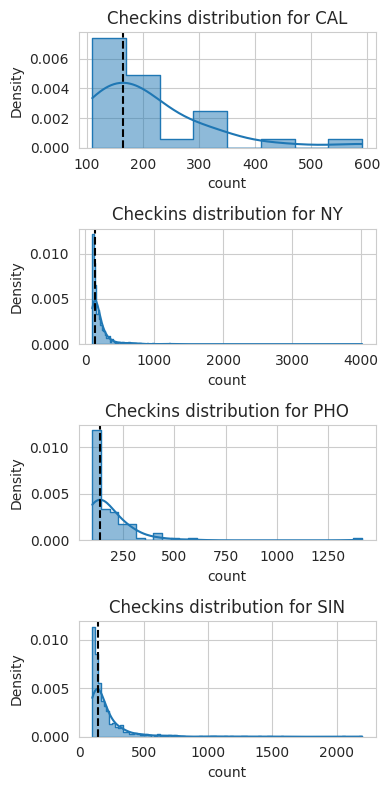

In [40]:
fig, axes = plt.subplots(4, 1, squeeze=False, figsize=(4, 8))
for i, city in enumerate(("CAL", "NY", "PHO", "SIN")):
    postprocessed_path = Path.cwd().parent / "data" / "flashback" / "partition" / city / "centralised" / "client_0.txt"
    df_postprocessed = pd.read_csv(postprocessed_path, sep="\t", header=None)
    checkin_distribution_postprocessed = df_postprocessed.loc[:, 0].value_counts()
    binwidth = (checkin_distribution_postprocessed.max() - checkin_distribution_postprocessed.min()) // 20

    histplot = sns.histplot(
        data=checkin_distribution_postprocessed,
        kde=True,
        element="step",
        stat="density",
        ax=axes[i, 0]
    )  # corresponds to histplot.get_lines()[0]
    mu = np.mean(checkin_distribution_postprocessed)
    sigma = np.std(checkin_distribution_postprocessed)  # standard deviation

    # Mode finding from KDE courtesy of https://stackoverflow.com/a/72222126
    x, y = histplot.get_lines()[0].get_data()
    mode = x[np.argmax(y)]
    print(f"mode={mode}")
    axes[i, 0].axvline(mode, ls="--", color="black")  # For demo purposes only

    axes[i, 0].set_title(f"Checkins distribution for {city}")

plt.tight_layout()
plt.show()

In [84]:
import math

In [90]:
df = pd.read_csv(Path.cwd().parent / "data" / "flashback" / "raw_data" / "CAL" / "CAL_checkin.csv")
df = df.loc[:, ["UserId"]]
distribution = df.loc[:, "UserId"].value_counts()
mode = find_mode(distribution)
# df.loc[:, "difference_from_mode"] = (df.loc[:, ["UserId"]] - mode).abs()
# df = df.sort_values(by="difference_from_mode", ascending=True)
# df # distribution - mode
assert len(distribution) == len(df.loc[:, "UserId"].unique())
users = len(df.loc[:, "UserId"].unique())
print(users)

(distribution - mode).abs().sort_values(kind="stable")[:math.ceil(0.15 * users)]

130


UserId
204593     0.442211
216211     1.442211
67279      1.442211
238217     1.557789
255357     2.557789
234005     3.557789
196461     4.557789
201143     7.557789
264040     8.557789
252848    10.442211
229317    10.442211
132941    10.442211
80439     10.557789
193643    10.557789
125958    12.557789
140752    13.557789
238329    14.442211
122380    14.557789
111727    15.442211
256556    15.442211
Name: count, dtype: float64

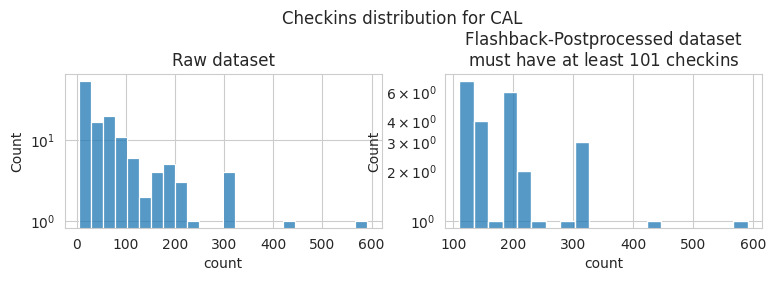

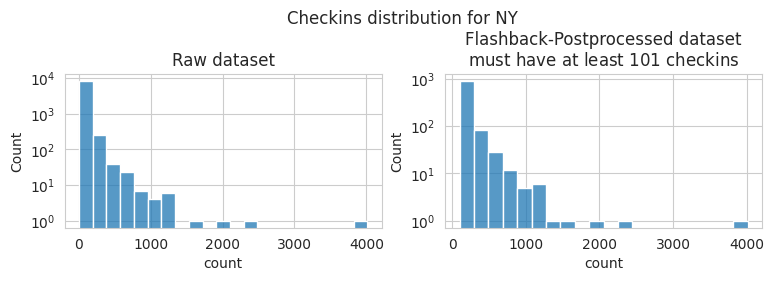

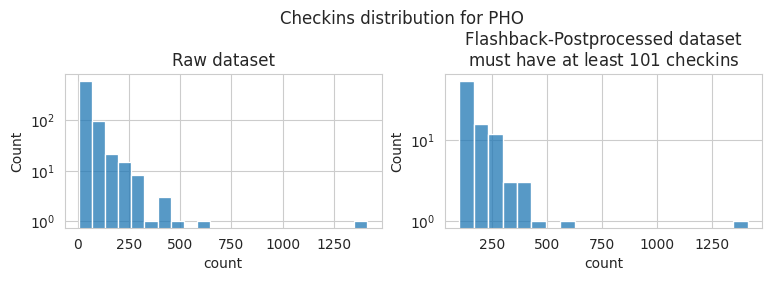

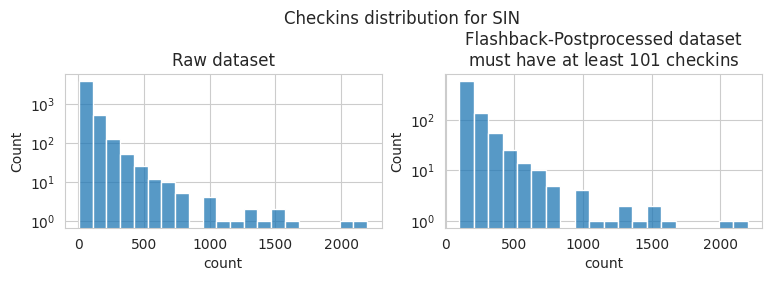

In [56]:
for city in ("CAL", "NY", "PHO", "SIN"):
    raw_path = Path.cwd().parent / "data" / "flashback" / "raw_data" / city / f"{city}_checkin.csv"
    df_raw = pd.read_csv(raw_path)
    checkin_distribution_raw = df_raw.loc[:, "UserId"].value_counts()

    postprocessed_path = Path.cwd().parent / "data" / "flashback" / "partition" / city / "centralised" / "client_0.txt"
    df_postprocessed = pd.read_csv(postprocessed_path, sep="\t", header=None)
    checkin_distribution_postprocessed = df_postprocessed.loc[:, 0].value_counts()
    binwidth = (checkin_distribution_postprocessed.max() - checkin_distribution_postprocessed.min()) // 20

    fig, axes = plt.subplots(1, 2, figsize=(9, 2), squeeze=False)
    sns.histplot(checkin_distribution_raw, stat="count", binwidth=binwidth, ax=axes[0, 0])
    sns.histplot(checkin_distribution_postprocessed, stat="count", binwidth=binwidth, ax=axes[0, 1])
    axes[0, 0].set_title("Raw dataset")
    axes[0, 0].set_yscale("log")
    axes[0, 1].set_title("Flashback-Postprocessed dataset\nmust have at least $101$ checkins")
    axes[0, 1].set_yscale("log")
    fig.suptitle(f"Checkins distribution for {city}", y=1.2)
    plt.show()

# 1. Results Analysis

In [52]:
NONFEDERATED_RESULTS_ROOT = Path.cwd().parent / "flashback-final-results" / "2024-03-24" / "05-15-35" / "+task"
MAIN_RESULTS_ROOT = Path.cwd().parent / "flashback-final-results" / "2024-03-24" / "05-15-21" / "+task"
POSTPROCESSED_PARTITION_ROOT = Path.cwd().parent / "data" / "flashback" / "partition"

SEEDS = (42, 361, 1337)

PLOTS_DESTINATION_DIR = Path.cwd() / "plots"

In [4]:
@dataclass
class Metrics:
    recall_at_1: List[Tuple[int, float]]
    recall_at_5: List[Tuple[int, float]]
    recall_at_10: List[Tuple[int, float]]
    mean_reciprocal_rank: List[Tuple[int, float]]

@dataclass
class History:
    losses_distributed: List[Tuple[int, float]]  # distributed test losses; list of (round, weighted averaged test loss at end of round >= 1)
    losses_centralised: List[Tuple[int, float]]  # centralised test losses; list of (round, test loss at end of round >= 0)
    metrics_distributed_fit: List[Tuple[int, float]]  # distributed train losses; list of (round, weighted averaged train loss at end of round >= 1)
    metrics_distributed: Metrics  # distributed test metrics; each subfield is a list of (round, weighted averaged test metric at end of round >= 1)
    metrics_centralised: Metrics  # centralised test metrics; each subfield is a list of (round, test metric at end of round >= 0)

def read_from_jsonpath(jsonpath: Path) -> History:
    with jsonpath.open("r") as f:
        dc = json.load(f)
    return History(
        losses_distributed=dc["losses_distributed"],
        losses_centralised=dc["losses_centralized"],
        metrics_distributed_fit=dc["metrics_distributed_fit"]["train_loss"],
        metrics_distributed=Metrics(
            recall_at_1=dc["metrics_distributed"]["recall@1"],
            recall_at_5=dc["metrics_distributed"]["recall@5"],
            recall_at_10=dc["metrics_distributed"]["recall@10"],
            mean_reciprocal_rank=dc["metrics_distributed"]["MAP"],
        ),
        metrics_centralised=Metrics(
            recall_at_1=dc["metrics_distributed"]["recall@1"],
            recall_at_5=dc["metrics_distributed"]["recall@5"],
            recall_at_10=dc["metrics_distributed"]["recall@10"],
            mean_reciprocal_rank=dc["metrics_distributed"]["MAP"],
        ),
    )

## 1.1. Hypothesis 1

We measure performance using Recall@1, Recall@5, Recall@10 and MRR. Recall in a ranking system is defined as:
    $$\mathit{Recall} = \frac{\#(\mathit{Relevant}\wedge\mathit{Recommended}\text{ in top $k$})}{\#\mathit{Relevant}}$$
Here, there is only one relevant POI (the "correct answer"). Thus this reduces to
$$\mathit{Recall} = \mathbb{1}_{\text{Correct answer is }\mathit{Recommended}\text{ in top $k$}}$$
[Source](https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54)


Sequence length is 20. 101 is aligned to length-100 $\mathbf{X}$ and length-100 $\mathbf{Y}$. Split into 80-20. Take as many non-overalpping 20s from each, dropping any left over.

For each length-20 sequence $\mathbf{X}?$ and correct answers $\mathbf{Y}$. Make 20 predictions. Consider $X[:t+1]$ predict $Y[t]$ for $t\in\{0,\dots,19\}$.

In [5]:
# [p.name for p in NONFEDERATED_RESULTS_ROOT.iterdir()]
seed = 42

# Hypothesis 0? / Baseline comparable with main paper
[
    MAIN_RESULTS_ROOT / f"flashback=centralised-cal-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=centralised-pho-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json",
]

# Hypothesis 1
def get_nonfederated_cal_jsonpaths(seed: int) -> List[Path]:
    return [
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal0-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal1-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal2-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal3-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal4-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal5-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal6-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal7-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal8-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal9-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal10-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal11-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal12-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal13-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal14-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal15-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal16-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal17-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal18-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal19-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal20-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal21-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal22-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal23-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal24-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal25-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal26-s{seed}" / "results" / "state" / "histories" / "history.json",
    ]

def get_nonfederated_pho_jsonpaths(seed: int) -> List[Path]:
    return [
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho0-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho1-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho2-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho3-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho4-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho5-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho6-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho7-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho8-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho9-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho10-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho11-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho12-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho13-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho14-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho15-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho16-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho17-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho18-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho19-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho20-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho21-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho22-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho23-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho24-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho25-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho26-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho27-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho28-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho29-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho30-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho31-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho32-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho33-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho34-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho35-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho36-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho37-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho38-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho39-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho40-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho41-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho42-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho43-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho44-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho45-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho46-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho47-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho48-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho49-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho50-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho51-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho52-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho53-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho54-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho55-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho56-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho57-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho58-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho59-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho60-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho61-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho62-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho63-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho64-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho65-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho66-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho67-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho68-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho69-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho70-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho71-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho72-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho73-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho74-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho75-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho76-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho77-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho78-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho79-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho80-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho81-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho82-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho83-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho84-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho85-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho86-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho87-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho88-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho89-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho90-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho91-s{seed}" / "results" / "state" / "histories" / "history.json",
    ]

[
    MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json",
]


[PosixPath('/home/jacky/Documents/part-iii/III Notes/src/L361-FL/project/l361-project-next-poi-prediction/flashback-final-results/2024-03-24/05-15-21/+task/flashback=federated-cal-ac-d0p0-s42/results/state/histories/history.json'),
 PosixPath('/home/jacky/Documents/part-iii/III Notes/src/L361-FL/project/l361-project-next-poi-prediction/flashback-final-results/2024-03-24/05-15-21/+task/flashback=federated-pho-ac-d0p0-s42/results/state/histories/history.json')]

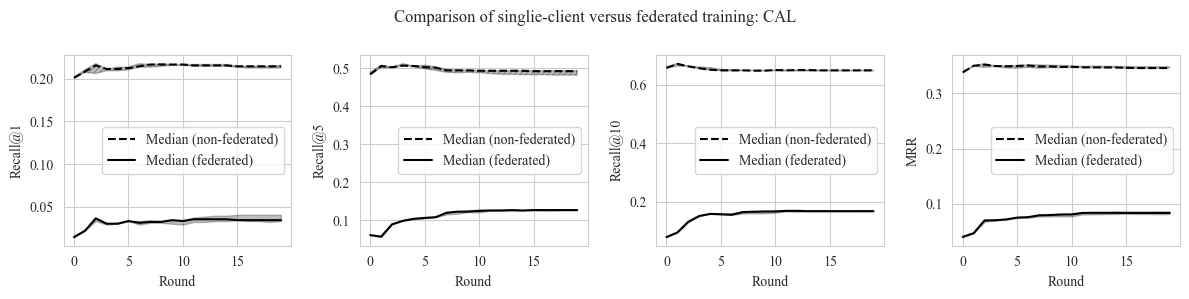

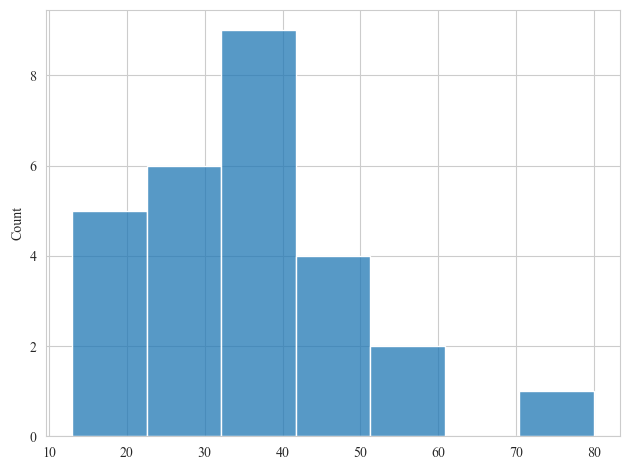

In [53]:
nonfl_ra1_perround_perseed = []
nonfl_ra5_perround_perseed = []
nonfl_ra10_perround_perseed = []
nonfl_mrr_perround_perseed = []
for seed in SEEDS:
    ra1_perround = []  # per-round metrics, weighted-averaged across all clients; will become np.arrays later
    ra5_perround = []  # per-round metrics, weighted-averaged across all clients; will become np.arrays later
    ra10_perround = []  # per-round metrics, weighted-averaged across all clients; will become np.arrays later
    mrr_perround = []  # per-round metrics, weighted-averaged across all clients; will become np.arrays later
    total_numtestseq = 0

    client_test_dataset_unique_locations = []
    for client_id, client_jsonpath in enumerate(get_nonfederated_cal_jsonpaths(seed)):
        history = read_from_jsonpath(client_jsonpath)

        dataset_path = POSTPROCESSED_PARTITION_ROOT / "all_clients_nonfederated" / f"CAL-{client_id}" / "centralised" / "client_0.txt"
        df = pd.read_csv(dataset_path, sep="\t", header=None)
        # with dataset_path.open("r") as f:
        #     checkin_count = sum([1 for _ in f])
        checkin_count = len(df)
        checkin_count_after_offbyone_alignment = checkin_count - 1
        number_of_train_sequences = int(checkin_count_after_offbyone_alignment * 0.8) // 20
        number_of_test_sequences = (checkin_count_after_offbyone_alignment - int(checkin_count_after_offbyone_alignment * 0.8)) // 20
        assert number_of_train_sequences > 0  # sanity check
        assert number_of_test_sequences > 0  # sanity check
        client_test_dataset_unique_locations.append(len(df.loc[number_of_train_sequences:, 4].unique()))

        # Append a length-20 np.array representing each metric at the end of each round, for a particular user.
        # We take weighted average over all users after the for-loop.
        ra1_perround.append(number_of_test_sequences * np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
        ra5_perround.append(number_of_test_sequences * np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
        ra10_perround.append(number_of_test_sequences * np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
        mrr_perround.append(number_of_test_sequences * np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))
        total_numtestseq += number_of_test_sequences

    ra1_perround = np.sum(ra1_perround, axis=0) / total_numtestseq  # length-20 np.array; weighted average ra1 at end of each round
    ra5_perround = np.sum(ra5_perround, axis=0) / total_numtestseq  # length-20 np.array; weighted average ra5 at end of each round
    ra10_perround = np.sum(ra10_perround, axis=0) / total_numtestseq  # length-20 np.array; weighted average ra10 at end of each round
    mrr_perround = np.sum(mrr_perround, axis=0) / total_numtestseq  # length-20 np.array; weighted average mrr at end of each round

    nonfl_ra1_perround_perseed.append(ra1_perround)
    nonfl_ra5_perround_perseed.append(ra5_perround)
    nonfl_ra10_perround_perseed.append(ra10_perround)
    nonfl_mrr_perround_perseed.append(mrr_perround)

fl_ra1_perround_perseed = []
fl_ra5_perround_perseed = []
fl_ra10_perround_perseed = []
fl_mrr_perround_perseed = []
for seed in SEEDS:
    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json")

    fl_ra1_perround_perseed.append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    fl_ra5_perround_perseed.append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    fl_ra10_perround_perseed.append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    fl_mrr_perround_perseed.append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))

fig, axes = plt.subplots(1, 4, figsize=(12, 3), squeeze=False)

plt.rcParams["font.family"] = "Times New Roman"
axes[0, 0].plot(np.median(nonfl_ra1_perround_perseed, axis=0), label="Median (non-federated)", color="black", linestyle="--")
axes[0, 0].fill_between(
    np.arange(20),
    np.min(nonfl_ra1_perround_perseed, axis=0),
    np.max(nonfl_ra1_perround_perseed, axis=0),
    # label="Range across 3 seeds",
    color="black",
    hatch="//////",
    alpha=0.25
)
axes[0, 0].plot(np.median(fl_ra1_perround_perseed, axis=0), label="Median (federated)", color="black")
axes[0, 0].fill_between(
    np.arange(20),
    np.min(fl_ra1_perround_perseed, axis=0),
    np.max(fl_ra1_perround_perseed, axis=0),
    # label="Range across 3 seeds",
    color="black",
    alpha=0.25
)
axes[0, 0].legend()
axes[0, 0].set_xlabel("Round")
axes[0, 0].set_ylabel("Recall@1")

axes[0, 1].plot(np.median(nonfl_ra5_perround_perseed, axis=0), label="Median (non-federated)", color="black", linestyle="--")
axes[0, 1].fill_between(
    np.arange(20),
    np.min(nonfl_ra5_perround_perseed, axis=0),
    np.max(nonfl_ra5_perround_perseed, axis=0),
    # label="Range across 3 seeds",
    color="black",
    hatch="//////",
    alpha=0.25
)
axes[0, 1].plot(np.median(fl_ra5_perround_perseed, axis=0), label="Median (federated)", color="black")
axes[0, 1].fill_between(
    np.arange(20),
    np.min(fl_ra5_perround_perseed, axis=0),
    np.max(fl_ra5_perround_perseed, axis=0),
    # label="Range across 3 seeds",
    color="black",
    alpha=0.25
)
axes[0, 1].legend()
axes[0, 1].set_xlabel("Round")
axes[0, 1].set_ylabel("Recall@5")

axes[0, 2].plot(np.median(nonfl_ra10_perround_perseed, axis=0), label="Median (non-federated)", color="black", linestyle="--")
axes[0, 2].fill_between(
    np.arange(20),
    np.min(nonfl_ra10_perround_perseed, axis=0),
    np.max(nonfl_ra10_perround_perseed, axis=0),
    # label="Range across 3 seeds",
    color="black",
    hatch="//////",
    alpha=0.25
)
axes[0, 2].plot(np.median(fl_ra10_perround_perseed, axis=0), label="Median (federated)", color="black")
axes[0, 2].fill_between(
    np.arange(20),
    np.min(fl_ra10_perround_perseed, axis=0),
    np.max(fl_ra10_perround_perseed, axis=0),
    # label="Range across 3 seeds",
    color="black",
    alpha=0.25
)
axes[0, 2].legend()
axes[0, 2].set_xlabel("Round")
axes[0, 2].set_ylabel("Recall@10")

axes[0, 3].plot(np.median(nonfl_mrr_perround_perseed, axis=0), label="Median (non-federated)", color="black", linestyle="--")
axes[0, 3].fill_between(
    np.arange(20),
    np.min(nonfl_mrr_perround_perseed, axis=0),
    np.max(nonfl_mrr_perround_perseed, axis=0),
    # label="Range across 3 seeds",
    color="black",
    hatch="//////",
    alpha=0.25
)
axes[0, 3].plot(np.median(fl_mrr_perround_perseed, axis=0), label="Median (federated)", color="black")
axes[0, 3].fill_between(
    np.arange(20),
    np.min(fl_mrr_perround_perseed, axis=0),
    np.max(fl_mrr_perround_perseed, axis=0),
    # label="Range across 3 seeds",
    color="black",
    alpha=0.25
)
axes[0, 3].legend()
axes[0, 3].set_xlabel("Round")
axes[0, 3].set_ylabel("MRR")
fig.suptitle("Comparison of singlie-client versus federated training: CAL")

plt.tight_layout()
plt.savefig(PLOTS_DESTINATION_DIR / "t.pdf", bbox_inches="tight")

fig, ax = plt.subplots()
sns.histplot(client_test_dataset_unique_locations, ax=ax)
plt.tight_layout()
plt.savefig(PLOTS_DESTINATION_DIR / "t.pdf", bbox_inches="tight")

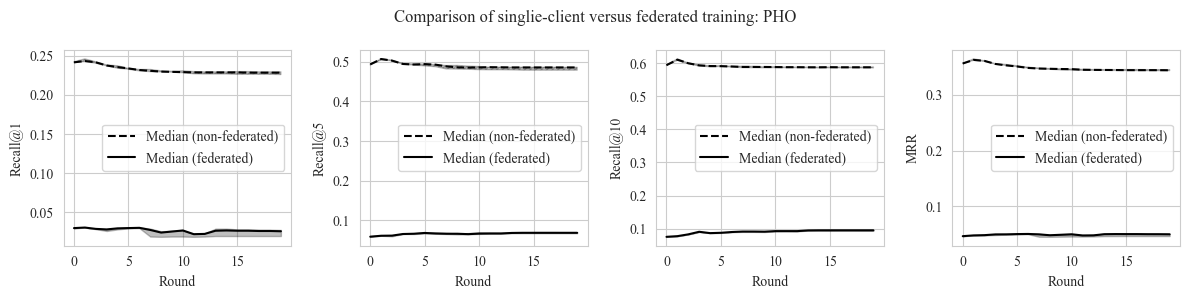

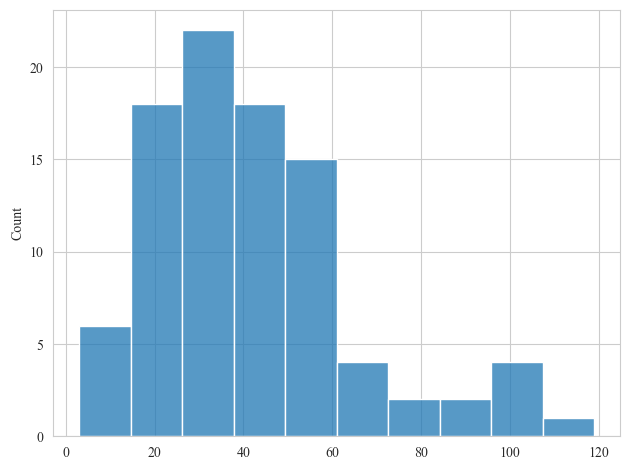

In [54]:
nonfl_ra1_perround_perseed = []
nonfl_ra5_perround_perseed = []
nonfl_ra10_perround_perseed = []
nonfl_mrr_perround_perseed = []
for seed in SEEDS:
    ra1_perround = []  # per-round metrics, weighted-averaged across all clients; will become np.arrays later
    ra5_perround = []  # per-round metrics, weighted-averaged across all clients; will become np.arrays later
    ra10_perround = []  # per-round metrics, weighted-averaged across all clients; will become np.arrays later
    mrr_perround = []  # per-round metrics, weighted-averaged across all clients; will become np.arrays later
    total_numtestseq = 0

    client_test_dataset_unique_locations = []
    for client_id, client_jsonpath in enumerate(get_nonfederated_pho_jsonpaths(seed)):
        history = read_from_jsonpath(client_jsonpath)

        dataset_path = POSTPROCESSED_PARTITION_ROOT / "all_clients_nonfederated" / f"PHO-{client_id}" / "centralised" / "client_0.txt"
        df = pd.read_csv(dataset_path, sep="\t", header=None)
        # with dataset_path.open("r") as f:
        #     checkin_count = sum([1 for _ in f])
        checkin_count = len(df)
        checkin_count_after_offbyone_alignment = checkin_count - 1
        number_of_train_sequences = int(checkin_count_after_offbyone_alignment * 0.8) // 20
        number_of_test_sequences = (checkin_count_after_offbyone_alignment - int(checkin_count_after_offbyone_alignment * 0.8)) // 20
        assert number_of_train_sequences > 0  # sanity check
        assert number_of_test_sequences > 0  # sanity check
        client_test_dataset_unique_locations.append(len(df.loc[number_of_train_sequences:, 4].unique()))

        # Append a length-20 np.array representing each metric at the end of each round, for a particular user.
        # We take weighted average over all users after the for-loop.
        ra1_perround.append(number_of_test_sequences * np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
        ra5_perround.append(number_of_test_sequences * np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
        ra10_perround.append(number_of_test_sequences * np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
        mrr_perround.append(number_of_test_sequences * np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))
        total_numtestseq += number_of_test_sequences

    ra1_perround = np.sum(ra1_perround, axis=0) / total_numtestseq  # length-20 np.array; weighted average ra1 at end of each round
    ra5_perround = np.sum(ra5_perround, axis=0) / total_numtestseq  # length-20 np.array; weighted average ra5 at end of each round
    ra10_perround = np.sum(ra10_perround, axis=0) / total_numtestseq  # length-20 np.array; weighted average ra10 at end of each round
    mrr_perround = np.sum(mrr_perround, axis=0) / total_numtestseq  # length-20 np.array; weighted average mrr at end of each round

    nonfl_ra1_perround_perseed.append(ra1_perround)
    nonfl_ra5_perround_perseed.append(ra5_perround)
    nonfl_ra10_perround_perseed.append(ra10_perround)
    nonfl_mrr_perround_perseed.append(mrr_perround)

fl_ra1_perround_perseed = []
fl_ra5_perround_perseed = []
fl_ra10_perround_perseed = []
fl_mrr_perround_perseed = []
for seed in SEEDS:
    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json")

    fl_ra1_perround_perseed.append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    fl_ra5_perround_perseed.append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    fl_ra10_perround_perseed.append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    fl_mrr_perround_perseed.append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))

fig, axes = plt.subplots(1, 4, figsize=(12, 3), squeeze=False)

plt.rcParams["font.family"] = "Times New Roman"
axes[0, 0].plot(np.median(nonfl_ra1_perround_perseed, axis=0), label="Median (non-federated)", color="black", linestyle="--")
axes[0, 0].fill_between(
    np.arange(20),
    np.min(nonfl_ra1_perround_perseed, axis=0),
    np.max(nonfl_ra1_perround_perseed, axis=0),
    # label="Range across 3 seeds",
    color="black",
    hatch="//////",
    alpha=0.25
)
axes[0, 0].plot(np.median(fl_ra1_perround_perseed, axis=0), label="Median (federated)", color="black")
axes[0, 0].fill_between(
    np.arange(20),
    np.min(fl_ra1_perround_perseed, axis=0),
    np.max(fl_ra1_perround_perseed, axis=0),
    # label="Range across 3 seeds",
    color="black",
    alpha=0.25
)
axes[0, 0].legend()
axes[0, 0].set_xlabel("Round")
axes[0, 0].set_ylabel("Recall@1")

axes[0, 1].plot(np.median(nonfl_ra5_perround_perseed, axis=0), label="Median (non-federated)", color="black", linestyle="--")
axes[0, 1].fill_between(
    np.arange(20),
    np.min(nonfl_ra5_perround_perseed, axis=0),
    np.max(nonfl_ra5_perround_perseed, axis=0),
    # label="Range across 3 seeds",
    color="black",
    hatch="//////",
    alpha=0.25
)
axes[0, 1].plot(np.median(fl_ra5_perround_perseed, axis=0), label="Median (federated)", color="black")
axes[0, 1].fill_between(
    np.arange(20),
    np.min(fl_ra5_perround_perseed, axis=0),
    np.max(fl_ra5_perround_perseed, axis=0),
    # label="Range across 3 seeds",
    color="black",
    alpha=0.25
)
axes[0, 1].legend()
axes[0, 1].set_xlabel("Round")
axes[0, 1].set_ylabel("Recall@5")

axes[0, 2].plot(np.median(nonfl_ra10_perround_perseed, axis=0), label="Median (non-federated)", color="black", linestyle="--")
axes[0, 2].fill_between(
    np.arange(20),
    np.min(nonfl_ra10_perround_perseed, axis=0),
    np.max(nonfl_ra10_perround_perseed, axis=0),
    # label="Range across 3 seeds",
    color="black",
    hatch="//////",
    alpha=0.25
)
axes[0, 2].plot(np.median(fl_ra10_perround_perseed, axis=0), label="Median (federated)", color="black")
axes[0, 2].fill_between(
    np.arange(20),
    np.min(fl_ra10_perround_perseed, axis=0),
    np.max(fl_ra10_perround_perseed, axis=0),
    # label="Range across 3 seeds",
    color="black",
    alpha=0.25
)
axes[0, 2].legend()
axes[0, 2].set_xlabel("Round")
axes[0, 2].set_ylabel("Recall@10")

axes[0, 3].plot(np.median(nonfl_mrr_perround_perseed, axis=0), label="Median (non-federated)", color="black", linestyle="--")
axes[0, 3].fill_between(
    np.arange(20),
    np.min(nonfl_mrr_perround_perseed, axis=0),
    np.max(nonfl_mrr_perround_perseed, axis=0),
    # label="Range across 3 seeds",
    color="black",
    hatch="//////",
    alpha=0.25
)
axes[0, 3].plot(np.median(fl_mrr_perround_perseed, axis=0), label="Median (federated)", color="black")
axes[0, 3].fill_between(
    np.arange(20),
    np.min(fl_mrr_perround_perseed, axis=0),
    np.max(fl_mrr_perround_perseed, axis=0),
    # label="Range across 3 seeds",
    color="black",
    alpha=0.25
)
axes[0, 3].legend()
axes[0, 3].set_xlabel("Round")
axes[0, 3].set_ylabel("MRR")
fig.suptitle("Comparison of singlie-client versus federated training: PHO")

plt.tight_layout()
plt.savefig(PLOTS_DESTINATION_DIR / "t.pdf", bbox_inches="tight")


fig, ax = plt.subplots()
sns.histplot(client_test_dataset_unique_locations, ax=ax)
plt.tight_layout()
plt.savefig(PLOTS_DESTINATION_DIR / "t.pdf", bbox_inches="tight")

Length of dataset (used as weights in FedAvg) is just <# full length-20 sequences>

## Hypothesis 2

### Quantity skew: Distribution of Client Dataset Sizes

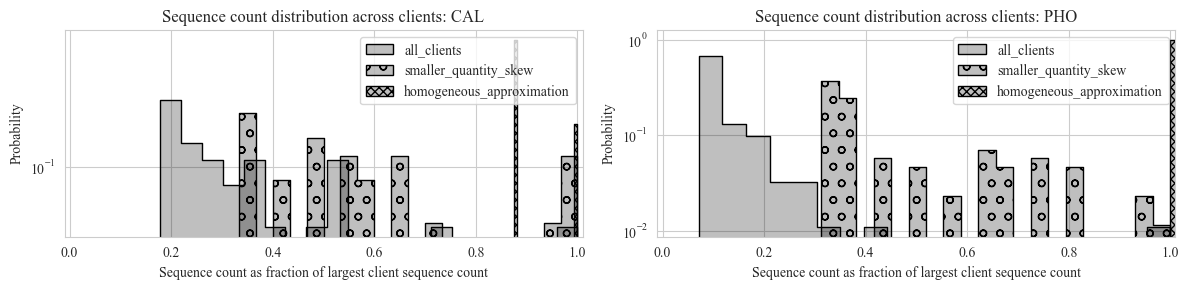

In [129]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3), squeeze=False)
for j, city in enumerate(("CAL", "PHO")):
    for heterogeneity in ("all_clients", "smaller_quantity_skew", "homogeneous_approximation"):
        dataset_path = POSTPROCESSED_PARTITION_ROOT / heterogeneity / city / "centralised" / "client_0.txt"
        df = pd.read_csv(dataset_path, sep="\t", header=None)
        num_checkins_per_user = df.loc[:, 0].value_counts()
        num_checkins_per_user -= 1  # after adjusting for off-by-one alignment of seq2seq input/output
        num_trainseq_per_user = np.floor(num_checkins_per_user * 0.8) // 20
        num_testseq_per_user = (num_checkins_per_user - np.floor(num_checkins_per_user * 0.8)) // 20
        num_seq_per_user = num_trainseq_per_user + num_testseq_per_user
        sns.histplot(
            alpha=0.25,
            legend=True,
            data=num_seq_per_user / num_seq_per_user.max(),
            fill=True,
            bins=20,
            # kde=True,
            element="step",
            stat="probability",
            common_norm=False,  # there is only 1 histogram here, so this is inconsequential
            common_bins=True,
            cbar=True,  # this is a univariate plot (1 dependent variable: # samples), so this is inconsequential
            color="black",
            label=heterogeneity,
            ax=axes[0, j]
        )

# Hatching courtesy of https://stackoverflow.com/a/35477440
hatches = ["", "o", "xxxx"]
for i, plot in enumerate(axes[0, 0].collections):
    # Set a different hatch for each bar
    plot.set_hatch(hatches[i])
for i ,plot in enumerate(axes[0, 1].collections):
    # Set a different hatch for each bar
    plot.set_hatch(hatches[i])


axes[0, 0].legend()
# axes[0, 0].set_yscale("log")
axes[0, 1].legend()
# axes[0, 1].set_yscale("log")

axes[0, 0].set_title("Sequence count distribution across clients: CAL")
axes[0, 0].set_xlabel("Sequence count as fraction of largest client sequence count")
axes[0, 0].set_xlim((-0.01, 1.01))
axes[0, 0].set_yscale("log")
axes[0, 1].set_title("Sequence count distribution across clients: PHO")
axes[0, 1].set_xlabel("Sequence count as fraction of largest client sequence count")
axes[0, 1].set_xlim((-0.01, 1.01))
axes[0, 1].set_yscale("log")

plt.tight_layout()
plt.savefig(PLOTS_DESTINATION_DIR / "t.pdf", bbox_inches="tight")



    # histplot = sns.histplot(
    #     alpha=0.15,
    #     legend=True,
    #     data=checkin_distribution_postprocessed,
    #     fill=True,
    #     kde=True,
    #     element="step",
    #     stat="density",
    #     common_norm=False,  # there is only 1 histogram here, so this is inconsequential
    #     common_bins=True,
    #     cbar=True,  # this is a univariate plot (1 dependent variable: # samples), so this is inconsequential
    #     palette="dark",
    #     ax=axes[i, 0]
    # )  # corresponds to histplot.get_lines()[0]

### Results

In [ ]:
# Hypothesis 2
[
    MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-cal-ha-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-cal-sqs-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-pho-ha-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-pho-sqs-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json",
]

## Hypothesis 3

In [ ]:
# Hypothesis 3
[
    MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p1-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p15-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p2-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p25-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p1-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p15-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p2-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p25-s{seed}" / "results" / "state" / "histories" / "history.json",
]